In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import pickle
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
os.listdir('../input/lish-moa')

['test_features.csv',
 'train_drug.csv',
 'train_features.csv',
 'train_targets_scored.csv',
 'train_targets_nonscored.csv',
 'sample_submission.csv']

In [3]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [4]:
train_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371


In [5]:
train_targets_scored.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_targets_nonscored.head(2)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.151,-0.775
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.381,-0.730


In [8]:
sample_submission.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [9]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASSED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## preprocess data

In [10]:
def drop_ctl_vehicle(train_features, test_features):
    
    train_features = train_features[train_features['cp_type'] != 'ctl_vehicle']
    test_features = test_features[test_features['cp_type'] != 'ctl_vehicle']
    target = train_targets_scored.iloc[train_features.index]
    train_features.reset_index(drop=True, inplace=True)
    test_features.reset_index(drop=True, inplace=True)
    
    return train_features, test_features, target

# train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
# test_features

In [11]:
def rank_gauss(train_features, test_features):
    
    train_features_ = train_features.copy()
    test_features_ = test_features.copy()
    
    GENES = [col for col in train_features_.columns if col.startswith('g-')]
    CELLS = [col for col in train_features_.columns if col.startswith('c-')]
    
    for col in (GENES + CELLS):

        transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
        vec_len = len(train_features_[col].values)
        vec_len_test = len(test_features_[col].values)
        raw_vec = train_features_[col].values.reshape(vec_len, 1)
        transformer.fit(raw_vec)

        train_features_[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
        test_features_[col] = transformer.transform(test_features_[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
        
    return train_features_, test_features_

# train_features1, test_features1 = rank_gauss(train_features, test_features)
# train_features1

In [12]:
def get_stats(train_features, test_features):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    for df in [train_features, test_features]:
#         df['g_sum'] = df[GENES].sum(axis = 1)
        df['g_mean'] = df[GENES].mean(axis = 1)
        df['g_std'] = df[GENES].std(axis = 1)
        df['g_kurt'] = df[GENES].kurtosis(axis = 1)
        df['g_skew'] = df[GENES].skew(axis = 1)
#         df['g_max'] = df[GENES].max(axis=1)
#         df['g_min'] = df[GENES].max(axis=1)
#         df['c_sum'] = df[CELLS].sum(axis=1)
        df['c_mean'] = df[CELLS].mean(axis = 1)
        df['c_std'] = df[CELLS].std(axis = 1)
        df['c_kurt'] = df[CELLS].kurtosis(axis = 1)
        df['c_skew'] = df[CELLS].skew(axis = 1)
#         df['c_max'] = df[CELLS].max(axis=1)
#         df['c_min'] = df[CELLS].min(axis=1)
#         df['gc_sum'] = df[GENES + CELLS].sum(axis = 1)
        df['gc_mean'] = df[GENES + CELLS].mean(axis = 1)
        df['gc_std'] = df[GENES + CELLS].std(axis = 1)
        df['gc_kurt'] = df[GENES + CELLS].kurtosis(axis = 1)
        df['gc_skew'] = df[GENES + CELLS].skew(axis = 1)
        
    return train_features, test_features

# train_features, test_features = get_stats(train_features, test_features)
# test_features

In [13]:
def get_pca(train_features, test_features, n_gs, n_cs):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    pca_gs = PCA(n_components = n_gs)
    pca_cs = PCA(n_components = n_cs)
    
    train_pca_gs = pca_gs.fit_transform(train_features[GENES])
    train_pca_cs = pca_cs.fit_transform(train_features[CELLS])
    test_pca_gs = pca_gs.transform(test_features[GENES])
    test_pca_cs = pca_cs.transform(test_features[CELLS])
    
    train_pca_gs = pd.DataFrame(train_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    train_pca_cs = pd.DataFrame(train_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    test_pca_gs = pd.DataFrame(test_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    test_pca_cs = pd.DataFrame(test_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    
    train_features = pd.concat([train_features, train_pca_gs, train_pca_cs], axis=1)
    test_features = pd.concat([test_features, test_pca_gs, test_pca_cs], axis=1)
    
    return train_features, test_features

# train_features, test_features = get_pca(train_features, test_features, n_gs=50, n_cs=15)
# test_features

In [14]:
def var_thresh(threshold, train_features, test_features):

    cols_numeric = [f for f in train_features.columns if f not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]
    mask = (train_features[cols_numeric].var() >= 0.8).values
    train_features_ = train_features[cols_numeric].loc[:, mask]
    test_features_ = test_features[cols_numeric].loc[:, mask]
    train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1).reset_index(drop=True)
    test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1).reset_index(drop=True)

    return train_features, test_features

# train_features, test_features = var_thresh_2(threshold=0.2, train_features=train_features, test_features=test_features)
# test_features

In [15]:
def get_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 0):
    
    GENES = [col for col in train.columns if col.startswith('g-')]
    CELLS = [col for col in train.columns if col.startswith('c-')]
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        
        return train, test
    
    train, test = create_cluster(train, test, GENES, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, CELLS, kind = 'c', n_clusters = n_clusters_c)
    
    return train, test

# train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)

In [16]:
def scaling(train_features, test_features):
    
    scaler = RobustScaler()
    train_features_ = train_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1)
    columns_ = train_features_.columns
    train_features_numerical = scaler.fit_transform(train_features_)
    test_features_numerical = scaler.transform(test_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1))
    train_features_ = pd.DataFrame(train_features_numerical)
    test_features_ = pd.DataFrame(test_features_numerical)
    train_features_ = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1)
    test_features_ = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1)
    
    return train_features_, test_features_

# train_features, test_features = scaling2(train_features, test_features)
# test_features

In [17]:
def make_folds(train, num_starts, num_splits):
    
    train_ = train.copy()
    folds = []

    # LOAD FILES
    train_feats = pd.read_csv('../input/lish-moa/train_features.csv')
    scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
    drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
    scored = scored.loc[train_feats['cp_type'] == 'trt_cp', :]
    drug = drug.loc[train_feats['cp_type'] == 'trt_cp', :]
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left') 

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[(vc <= 6) | (vc == 12) | (vc == 18)].index.sort_values()
    vc2 = vc.loc[(vc > 6) & (vc != 12) & (vc != 18)].index.sort_values()

    for seed in range(num_starts):

        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}; dct2 = {}
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop = True)
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        scored['fold'] = scored.drug_id.map(dct1)
        scored.loc[scored.fold.isna(),'fold'] =\
            scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
        scored.fold = scored.fold.astype('int8')
        folds.append(scored.fold.values)

        del scored['fold']
        
        for i in range(len(folds)):
            train_[f'seed{i}'] = folds[i]

    return train_

In [18]:
def make_folds_old(train, n_splits):
    
    folds = train.copy()

    mskf = MultilabelStratifiedKFold(n_splits)

    for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
        folds.loc[v_idx, 'kfold'] = int(f)

    folds['kfold'] = folds['kfold'].astype(int)
    
    return folds

In [19]:
def preprocessor(train_features, test_features):
    
#     # drop_ctl_vehicle
#     train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
    
    # rank_gauss
    train_features, test_features = rank_gauss(train_features, test_features)
    print('rank_gauss: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # stats
    train_features, test_features = get_stats(train_features, test_features)
    print('get_stats: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # pca
    train_features, test_features = get_pca(train_features, test_features, n_gs=600, n_cs=50) 
    print('get_pca: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # var_thresh
    train_features, test_features = var_thresh(threshold=0.8, train_features=train_features, test_features=test_features)
    print('var_thresh: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
#     # clustering
#     train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)
#     print('clustering: done')
#     print('train_features.shape', train_features.shape)
#     print('test_features.shape', test_features.shape)
    
#     # Scaling
#     train_features, test_features = scaling(train_features, test_features)
#     print('scaling: done')
    
    # data merge
    train = train_features.merge(train_targets_scored, on='sig_id')
    train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
    test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

    target = train[train_targets_scored.columns]
    
    train = train.drop('cp_type', axis=1)
    test = test.drop('cp_type', axis=1)
    
    return train, target, test  

train, target, test = preprocessor(train_features, test_features)

rank_gauss: done
train_features.shape (23814, 876)
test_features.shape (3982, 876)
get_stats: done
train_features.shape (23814, 888)
test_features.shape (3982, 888)
get_pca: done
train_features.shape (23814, 1538)
test_features.shape (3982, 1538)
var_thresh: done
train_features.shape (23814, 1044)
test_features.shape (3982, 1044)


In [20]:
folds = make_folds_old(train, n_splits=5)

In [21]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
feature_cols = [c for c in pd.get_dummies(train, columns=['cp_time', 'cp_dose']).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id']]
len(feature_cols)

1045

### shape check

In [22]:
print(f'train.shape: {train.shape}')
print(f'folds.shape: {folds.shape}')
print(f'test.shape: {test.shape}')
print(f'target.shape: {target.shape}')
print(f'sample_submission.shape: {sample_submission.shape}')

train.shape: (21948, 1249)
folds.shape: (21948, 1250)
test.shape: (3624, 1043)
target.shape: (21948, 207)
sample_submission.shape: (3982, 207)


### save data

In [23]:
all_data = {
    'train': train, 
    'folds': folds, 
    'test': test, 
    'target': target, 
    'sample_submission': sample_submission
}

In [24]:
with open('all_data_Simple.pickle', 'wb') as f:
    pickle.dump(all_data, f)

## Dataset Classes

In [25]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float), 
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

### HyperParameters

In [26]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 35
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-6
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False
smoothing = 0.001
p_min = smoothing
p_max = 1 - smoothing

num_features = len(feature_cols)
num_targets = len(target_cols)
hidden_size_1 = 1024
hidden_size_2 = 1024

### Model

In [27]:
class Model_Simple(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size_1, hidden_size_2):
        super(Model_Simple, self).__init__()
        
        self.batch_norm1 = nn.BatchNorm1d(num_features=num_features)
        self.dropout1 = nn.Dropout(0.1)
        self.Linear1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size_1))
        self.leaky_relu1 = nn.LeakyReLU()
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size_1)
        self.dropout2 = nn.Dropout(0.4)
        self.Linear2 = nn.utils.weight_norm(nn.Linear(hidden_size_1, hidden_size_2))
        self.leaky_relu2 = nn.LeakyReLU()
        
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size_2)
        self.dropout3 = nn.Dropout(0.4)
        self.Linear3 = nn.utils.weight_norm(nn.Linear(hidden_size_2, num_targets))
        
    def recalibrate_layer(self, layer):

        if(torch.isnan(layer.weight_v).sum() > 0):
            print ('recalibrate layer.weight_v')
            layer.weight_v = torch.nn.Parameter(torch.where(torch.isnan(layer.weight_v), torch.zeros_like(layer.weight_v), layer.weight_v))
            layer.weight_v = torch.nn.Parameter(layer.weight_v + 1e-7)

        if(torch.isnan(layer.weight).sum() > 0):
            print ('recalibrate layer.weight')
            layer.weight = torch.where(torch.isnan(layer.weight), torch.zeros_like(layer.weight), layer.weight)
            layer.weight += 1e-7
        
        
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        self.recalibrate_layer(self.Linear1)
        x = self.Linear1(x)
        x = self.leaky_relu1(x)
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        self.recalibrate_layer(layer=self.Linear2)
        x = self.Linear2(x)
        x = self.leaky_relu2(x)
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        self.recalibrate_layer(layer=self.Linear3)
        x = self.Linear3(x)
        
        return x

### training function

In [28]:
def train_fn(model, optimizer, scheduler, loss_tr, loss_fn, dataloader, device):
    rejected = 0
    model.train()
    final_loss = 0
    final_metric = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        if len(inputs) > 1:
            outputs = model(inputs)
            loss = loss_tr(outputs, targets)
            metric = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            final_loss += loss.item()
            final_metric += metric.item()
        
        else:
            rejected += len(inputs)
            
        
    final_loss /= (len(dataloader) - rejected)
    final_metric /= (len(dataloader) - rejected)
    
    return final_loss, final_metric

In [29]:
def valid_fn(model, loss_tr, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    final_metric = 0
    valid_preds = []
    
    for data in dataloader:
        
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_tr(outputs, targets)
        metric = loss_fn(outputs, targets)
        final_loss += loss.item()
        final_metric += metric.item()
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)
        valid_preds.append(outputs.numpy())
        
    final_loss /= len(dataloader)
    final_metric /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
        
    return final_loss, final_metric, valid_preds

In [30]:
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)    
        preds.append(outputs.numpy())
        
    preds = np.concatenate(preds)
        
    return preds

### loss_function

In [31]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets, n_classes, smoothing=0.0):
        assert 0 <= smoothing <= 1
        with torch.no_grad():
            targets = targets * (1 - smoothing) + torch.ones_like(targets).to(DEVICE) * smoothing / n_classes
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss()._smooth(targets, inputs.shape[1], self.smoothing)

        if self.weight is not None:
            inputs = inputs * self.weight.unsqueeze(0)

        loss = F.binary_cross_entropy_with_logits(inputs, targets)

        return loss

In [32]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets
    
    def forward(self, inputs, targets):
            targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
                self.smoothing)
            loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

            if  self.reduction == 'sum':
                loss = loss.sum()
            elif  self.reduction == 'mean':
                loss = loss.mean()

            return loss

### Single fold training

In [33]:
def run_training(fold, seed, EPOCHS, LEARNING_RATE):
    
    print(f'==========FOLD{fold+1}==========')
    
    
    seed_everything(seed)
    
    train_losses = list()
    valid_losses = list()
    CV = list()
    
    train = pd.get_dummies(folds, columns=['cp_time', 'cp_dose'])
    test_ = pd.get_dummies(test, columns=['cp_time', 'cp_dose'])
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index()
    valid_df = train[train['kfold'] == fold].reset_index()
    
    x_train, y_train = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid = valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model_Simple(num_features=num_features,
                      num_targets=num_targets, 
                      hidden_size_1=hidden_size_1, 
                      hidden_size_2=hidden_size_2)
    

    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.3, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader)) 
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing=smoothing)
    
    early_stoppping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        print(f'-----EPOCH{epoch+1}-----')
        
        train_loss, train_metric = train_fn(model, optimizer, scheduler, loss_tr, loss_fn, trainloader, DEVICE)
        print(f'train_loss: {train_loss:.5f}, train_metric: {train_metric:.5f}')
        train_losses.append(train_metric)
        valid_loss, valid_metric, valid_preds = valid_fn(model, loss_tr, loss_fn, validloader, DEVICE)
        print(f'valid_loss: {valid_loss:.5f}, valid_metric: {valid_metric:.5f}')
        valid_losses.append(valid_metric)
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f'Simple_FOLD{fold+1}_SEED{seed}.pth')
            
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
                
    y_true = train_targets_scored[target_cols].values
                
    cv = 0
    for i in range(len(target_cols)):
        cv_ = log_loss(y_true[val_idx, i], oof[val_idx, i], labels=[0, 1])
        cv += cv_ / len(target_cols)
                
    plt.plot(train_losses, label='train_losses')
    plt.plot(valid_losses, label='valid_losses')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim([1e-2, 2e-2])
    plt.title(f'fold{fold+1} losses')
    plt.show()
                
    #-----------------------PREDICTION-------------------------
                
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model_Simple(num_features=num_features, 
                             num_targets=num_targets, 
                             hidden_size_1=hidden_size_1,
                             hidden_size_2=hidden_size_2)
    
    model.load_state_dict(torch.load(f'Simple_FOLD{fold+1}_SEED{seed}.pth'))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions, cv

In [34]:
def run_k_fold(NFOLD, seed, EPOCH, LEARNING_RATE):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    CVs = list()
    
    for fold in range(NFOLDS):
        oof_, pred_, cv_ = run_training(fold, seed, EPOCH, LEARNING_RATE)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        CVs.append(cv_)
        
    return oof, predictions, CVs

device used: cuda
 
SEED : 0

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73728, train_metric: 0.73727
valid_loss: 0.64289, valid_metric: 0.64283
-----EPOCH2-----
train_loss: 0.26923, train_metric: 0.26829
valid_loss: 0.03639, valid_metric: 0.03441
-----EPOCH3-----
train_loss: 0.02809, train_metric: 0.02564
valid_loss: 0.02297, valid_metric: 0.02023
-----EPOCH4-----
train_loss: 0.02312, train_metric: 0.02019
valid_loss: 0.02203, valid_metric: 0.01895
-----EPOCH5-----
train_loss: 0.02243, train_metric: 0.01929
valid_loss: 0.02167, valid_metric: 0.01851
-----EPOCH6-----
train_loss: 0.02164, train_metric: 0.01843
valid_loss: 0.02094, valid_metric: 0.01767
-----EPOCH7-----
train_loss: 0.02095, train_metric: 0.01772
valid_loss: 0.02068, valid_metric: 0.01745
-----EPOCH8-----
train_loss: 0.02051, train_metric: 0.01728
valid_loss: 0.02042, valid_metric: 0.01722
-----EPOCH9-----
train_loss: 0.02023, train_metric: 0.01701
valid_loss: 0.02030, valid_metric: 0.01710
-----EPOCH10-----

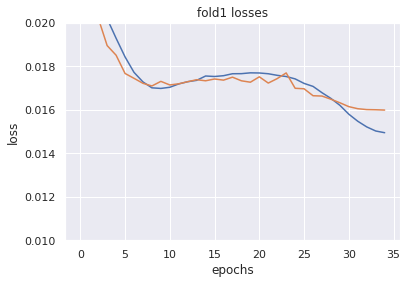

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73643, train_metric: 0.73642
valid_loss: 0.64270, valid_metric: 0.64264
-----EPOCH2-----
train_loss: 0.26721, train_metric: 0.26627
valid_loss: 0.03385, valid_metric: 0.03184
-----EPOCH3-----
train_loss: 0.02800, train_metric: 0.02555
valid_loss: 0.02339, valid_metric: 0.02063
-----EPOCH4-----
train_loss: 0.02330, train_metric: 0.02037
valid_loss: 0.02199, valid_metric: 0.01893
-----EPOCH5-----
train_loss: 0.02230, train_metric: 0.01919
valid_loss: 0.02132, valid_metric: 0.01817
-----EPOCH6-----
train_loss: 0.02150, train_metric: 0.01829
valid_loss: 0.02112, valid_metric: 0.01785
-----EPOCH7-----
train_loss: 0.02092, train_metric: 0.01768
valid_loss: 0.02063, valid_metric: 0.01738
-----EPOCH8-----
train_loss: 0.02038, train_metric: 0.01715
valid_loss: 0.02045, valid_metric: 0.01721
-----EPOCH9-----
train_loss: 0.02013, train_metric: 0.01691
valid_loss: 0.02016, valid_metric: 0.01697
-----EPOCH10-----
train_loss: 0.02009, train_me

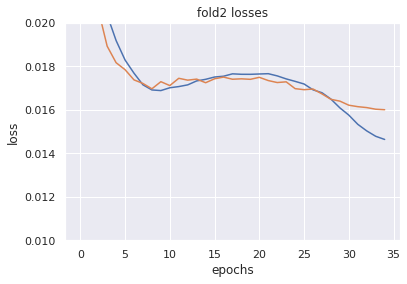

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73642, train_metric: 0.73641
valid_loss: 0.64479, valid_metric: 0.64473
-----EPOCH2-----
train_loss: 0.26927, train_metric: 0.26833
valid_loss: 0.03489, valid_metric: 0.03290
-----EPOCH3-----
train_loss: 0.02818, train_metric: 0.02573
valid_loss: 0.02388, valid_metric: 0.02116
-----EPOCH4-----
train_loss: 0.02341, train_metric: 0.02047
valid_loss: 0.02165, valid_metric: 0.01849
-----EPOCH5-----
train_loss: 0.02233, train_metric: 0.01921
valid_loss: 0.02109, valid_metric: 0.01798
-----EPOCH6-----
train_loss: 0.02156, train_metric: 0.01836
valid_loss: 0.02096, valid_metric: 0.01779
-----EPOCH7-----
train_loss: 0.02087, train_metric: 0.01765
valid_loss: 0.02040, valid_metric: 0.01717
-----EPOCH8-----
train_loss: 0.02034, train_metric: 0.01711
valid_loss: 0.02027, valid_metric: 0.01706
-----EPOCH9-----
train_loss: 0.02015, train_metric: 0.01693
valid_loss: 0.02037, valid_metric: 0.01713
-----EPOCH10-----
train_loss: 0.02008, train_me

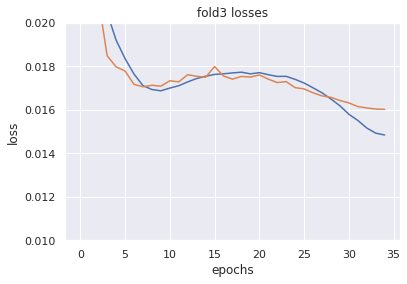

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73652, train_metric: 0.73651
valid_loss: 0.64537, valid_metric: 0.64531
-----EPOCH2-----
train_loss: 0.26848, train_metric: 0.26754
valid_loss: 0.03351, valid_metric: 0.03148
-----EPOCH3-----
train_loss: 0.02803, train_metric: 0.02558
valid_loss: 0.02311, valid_metric: 0.02032
-----EPOCH4-----
train_loss: 0.02328, train_metric: 0.02034
valid_loss: 0.02180, valid_metric: 0.01879
-----EPOCH5-----
train_loss: 0.02244, train_metric: 0.01932
valid_loss: 0.02141, valid_metric: 0.01826
-----EPOCH6-----
train_loss: 0.02166, train_metric: 0.01845
valid_loss: 0.02090, valid_metric: 0.01770
-----EPOCH7-----
train_loss: 0.02095, train_metric: 0.01772
valid_loss: 0.02053, valid_metric: 0.01729
-----EPOCH8-----
train_loss: 0.02045, train_metric: 0.01723
valid_loss: 0.02031, valid_metric: 0.01708
-----EPOCH9-----
train_loss: 0.02017, train_metric: 0.01695
valid_loss: 0.02029, valid_metric: 0.01714
-----EPOCH10-----
train_loss: 0.02009, train_me

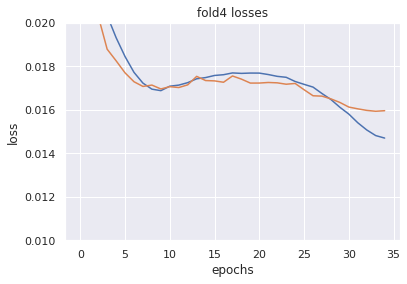

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73623, train_metric: 0.73622
valid_loss: 0.64568, valid_metric: 0.64562
-----EPOCH2-----
train_loss: 0.26840, train_metric: 0.26746
valid_loss: 0.03327, valid_metric: 0.03126
-----EPOCH3-----
train_loss: 0.02844, train_metric: 0.02598
valid_loss: 0.02338, valid_metric: 0.02060
-----EPOCH4-----
train_loss: 0.02323, train_metric: 0.02029
valid_loss: 0.02180, valid_metric: 0.01887
-----EPOCH5-----
train_loss: 0.02222, train_metric: 0.01910
valid_loss: 0.02146, valid_metric: 0.01835
-----EPOCH6-----
train_loss: 0.02157, train_metric: 0.01835
valid_loss: 0.02083, valid_metric: 0.01762
-----EPOCH7-----
train_loss: 0.02094, train_metric: 0.01771
valid_loss: 0.02065, valid_metric: 0.01747
-----EPOCH8-----
train_loss: 0.02050, train_metric: 0.01728
valid_loss: 0.02049, valid_metric: 0.01725
-----EPOCH9-----
train_loss: 0.02008, train_metric: 0.01686
valid_loss: 0.02031, valid_metric: 0.01711
-----EPOCH10-----
train_loss: 0.02015, train_me

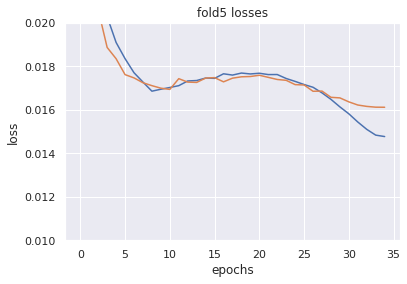

 
SEED : 1

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73677, train_metric: 0.73676
valid_loss: 0.63959, valid_metric: 0.63952
-----EPOCH2-----
train_loss: 0.26965, train_metric: 0.26872
valid_loss: 0.03503, valid_metric: 0.03302
-----EPOCH3-----
train_loss: 0.02831, train_metric: 0.02585
valid_loss: 0.02300, valid_metric: 0.02022
-----EPOCH4-----
train_loss: 0.02321, train_metric: 0.02027
valid_loss: 0.02170, valid_metric: 0.01857
-----EPOCH5-----
train_loss: 0.02236, train_metric: 0.01923
valid_loss: 0.02119, valid_metric: 0.01802
-----EPOCH6-----
train_loss: 0.02157, train_metric: 0.01836
valid_loss: 0.02105, valid_metric: 0.01781
-----EPOCH7-----
train_loss: 0.02083, train_metric: 0.01760
valid_loss: 0.02073, valid_metric: 0.01743
-----EPOCH8-----
train_loss: 0.02045, train_metric: 0.01722
valid_loss: 0.02040, valid_metric: 0.01718
-----EPOCH9-----
train_loss: 0.02011, train_metric: 0.01689
valid_loss: 0.02044, valid_metric: 0.01720
-----EPOCH10-----
train_loss: 0.020

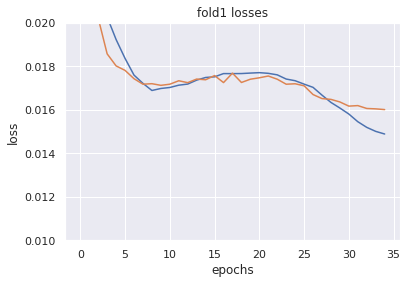

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73742, train_metric: 0.73741
valid_loss: 0.64033, valid_metric: 0.64026
-----EPOCH2-----
train_loss: 0.27086, train_metric: 0.26992
valid_loss: 0.03431, valid_metric: 0.03232
-----EPOCH3-----
train_loss: 0.02801, train_metric: 0.02557
valid_loss: 0.02317, valid_metric: 0.02043
-----EPOCH4-----
train_loss: 0.02315, train_metric: 0.02022
valid_loss: 0.02186, valid_metric: 0.01885
-----EPOCH5-----
train_loss: 0.02267, train_metric: 0.01953
valid_loss: 0.02140, valid_metric: 0.01823
-----EPOCH6-----
train_loss: 0.02158, train_metric: 0.01837
valid_loss: 0.02080, valid_metric: 0.01763
-----EPOCH7-----
train_loss: 0.02088, train_metric: 0.01766
valid_loss: 0.02058, valid_metric: 0.01741
-----EPOCH8-----
train_loss: 0.02041, train_metric: 0.01719
valid_loss: 0.02058, valid_metric: 0.01740
-----EPOCH9-----
train_loss: 0.02021, train_metric: 0.01700
valid_loss: 0.02036, valid_metric: 0.01715
-----EPOCH10-----
train_loss: 0.02009, train_me

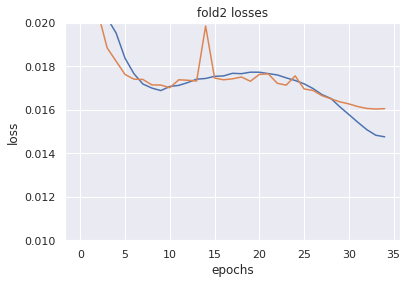

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73716, train_metric: 0.73715
valid_loss: 0.64269, valid_metric: 0.64263
-----EPOCH2-----
train_loss: 0.27029, train_metric: 0.26935
valid_loss: 0.03356, valid_metric: 0.03154
-----EPOCH3-----
train_loss: 0.02785, train_metric: 0.02540
valid_loss: 0.02305, valid_metric: 0.02031
-----EPOCH4-----
train_loss: 0.02340, train_metric: 0.02046
valid_loss: 0.02157, valid_metric: 0.01846
-----EPOCH5-----
train_loss: 0.02234, train_metric: 0.01921
valid_loss: 0.02124, valid_metric: 0.01799
-----EPOCH6-----
train_loss: 0.02170, train_metric: 0.01850
valid_loss: 0.02082, valid_metric: 0.01767
-----EPOCH7-----
train_loss: 0.02099, train_metric: 0.01777
valid_loss: 0.02042, valid_metric: 0.01721
-----EPOCH8-----
train_loss: 0.02043, train_metric: 0.01720
valid_loss: 0.02048, valid_metric: 0.01725
-----EPOCH9-----
train_loss: 0.02020, train_metric: 0.01698
valid_loss: 0.02013, valid_metric: 0.01695
-----EPOCH10-----
train_loss: 0.02011, train_me

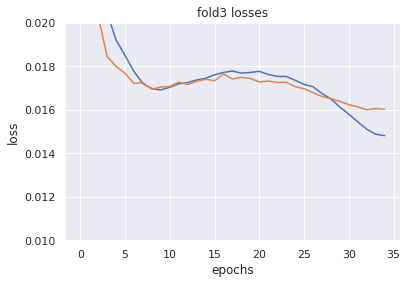

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73707, train_metric: 0.73706
valid_loss: 0.63979, valid_metric: 0.63972
-----EPOCH2-----
train_loss: 0.27026, train_metric: 0.26932
valid_loss: 0.03375, valid_metric: 0.03174
-----EPOCH3-----
train_loss: 0.02858, train_metric: 0.02613
valid_loss: 0.02390, valid_metric: 0.02105
-----EPOCH4-----
train_loss: 0.02350, train_metric: 0.02054
valid_loss: 0.02190, valid_metric: 0.01888
-----EPOCH5-----
train_loss: 0.02241, train_metric: 0.01928
valid_loss: 0.02129, valid_metric: 0.01805
-----EPOCH6-----
train_loss: 0.02164, train_metric: 0.01844
valid_loss: 0.02089, valid_metric: 0.01763
-----EPOCH7-----
train_loss: 0.02090, train_metric: 0.01767
valid_loss: 0.02047, valid_metric: 0.01719
-----EPOCH8-----
train_loss: 0.02041, train_metric: 0.01717
valid_loss: 0.02049, valid_metric: 0.01721
-----EPOCH9-----
train_loss: 0.02018, train_metric: 0.01696
valid_loss: 0.02023, valid_metric: 0.01704
-----EPOCH10-----
train_loss: 0.02012, train_me

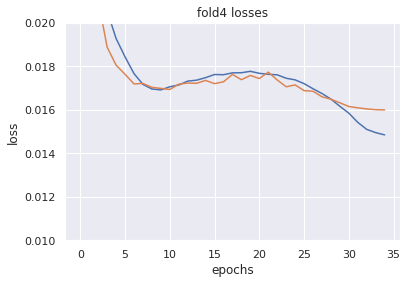

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73670, train_metric: 0.73669
valid_loss: 0.64558, valid_metric: 0.64552
-----EPOCH2-----
train_loss: 0.26837, train_metric: 0.26743
valid_loss: 0.03458, valid_metric: 0.03258
-----EPOCH3-----
train_loss: 0.02786, train_metric: 0.02542
valid_loss: 0.02353, valid_metric: 0.02081
-----EPOCH4-----
train_loss: 0.02325, train_metric: 0.02032
valid_loss: 0.02193, valid_metric: 0.01895
-----EPOCH5-----
train_loss: 0.02255, train_metric: 0.01942
valid_loss: 0.02208, valid_metric: 0.01881
-----EPOCH6-----
train_loss: 0.02165, train_metric: 0.01843
valid_loss: 0.02086, valid_metric: 0.01764
-----EPOCH7-----
train_loss: 0.02108, train_metric: 0.01785
valid_loss: 0.02067, valid_metric: 0.01745
-----EPOCH8-----
train_loss: 0.02052, train_metric: 0.01729
valid_loss: 0.02037, valid_metric: 0.01717
-----EPOCH9-----
train_loss: 0.02019, train_metric: 0.01697
valid_loss: 0.02052, valid_metric: 0.01735
-----EPOCH10-----
train_loss: 0.02012, train_me

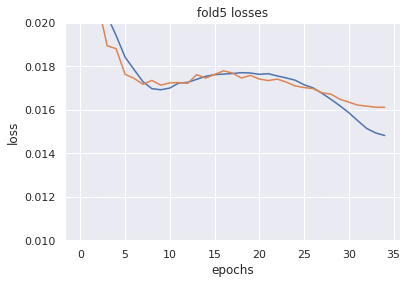

 
SEED : 2

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73548, train_metric: 0.73546
valid_loss: 0.64506, valid_metric: 0.64500
-----EPOCH2-----
train_loss: 0.26749, train_metric: 0.26655
valid_loss: 0.03409, valid_metric: 0.03209
-----EPOCH3-----
train_loss: 0.02794, train_metric: 0.02549
valid_loss: 0.02460, valid_metric: 0.02187
-----EPOCH4-----
train_loss: 0.02336, train_metric: 0.02041
valid_loss: 0.02193, valid_metric: 0.01883
-----EPOCH5-----
train_loss: 0.02213, train_metric: 0.01899
valid_loss: 0.02114, valid_metric: 0.01791
-----EPOCH6-----
train_loss: 0.02162, train_metric: 0.01841
valid_loss: 0.02077, valid_metric: 0.01761
-----EPOCH7-----
train_loss: 0.02086, train_metric: 0.01763
valid_loss: 0.02049, valid_metric: 0.01726
-----EPOCH8-----
train_loss: 0.02036, train_metric: 0.01713
valid_loss: 0.02038, valid_metric: 0.01716
-----EPOCH9-----
train_loss: 0.02013, train_metric: 0.01691
valid_loss: 0.02038, valid_metric: 0.01714
-----EPOCH10-----
train_loss: 0.020

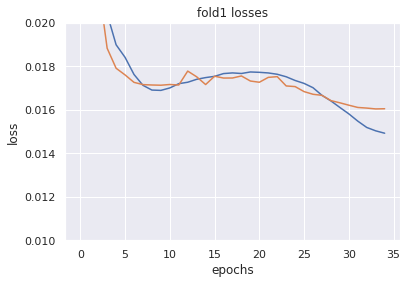

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73544, train_metric: 0.73542
valid_loss: 0.64309, valid_metric: 0.64303
-----EPOCH2-----
train_loss: 0.26846, train_metric: 0.26752
valid_loss: 0.03609, valid_metric: 0.03409
-----EPOCH3-----
train_loss: 0.02797, train_metric: 0.02552
valid_loss: 0.02325, valid_metric: 0.02052
-----EPOCH4-----
train_loss: 0.02348, train_metric: 0.02056
valid_loss: 0.02178, valid_metric: 0.01873
-----EPOCH5-----
train_loss: 0.02212, train_metric: 0.01898
valid_loss: 0.02163, valid_metric: 0.01850
-----EPOCH6-----
train_loss: 0.02147, train_metric: 0.01826
valid_loss: 0.02074, valid_metric: 0.01753
-----EPOCH7-----
train_loss: 0.02070, train_metric: 0.01746
valid_loss: 0.02053, valid_metric: 0.01728
-----EPOCH8-----
train_loss: 0.02031, train_metric: 0.01708
valid_loss: 0.02038, valid_metric: 0.01715
-----EPOCH9-----
train_loss: 0.02002, train_metric: 0.01680
valid_loss: 0.02028, valid_metric: 0.01708
-----EPOCH10-----
train_loss: 0.02000, train_me

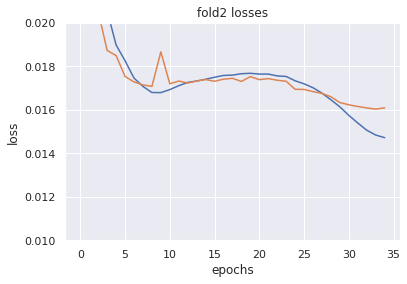

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73510, train_metric: 0.73508
valid_loss: 0.64002, valid_metric: 0.63996
-----EPOCH2-----
train_loss: 0.26710, train_metric: 0.26615
valid_loss: 0.03366, valid_metric: 0.03165
-----EPOCH3-----
train_loss: 0.02815, train_metric: 0.02570
valid_loss: 0.02293, valid_metric: 0.02019
-----EPOCH4-----
train_loss: 0.02306, train_metric: 0.02012
valid_loss: 0.02150, valid_metric: 0.01839
-----EPOCH5-----
train_loss: 0.02232, train_metric: 0.01919
valid_loss: 0.02110, valid_metric: 0.01800
-----EPOCH6-----
train_loss: 0.02159, train_metric: 0.01839
valid_loss: 0.02089, valid_metric: 0.01765
-----EPOCH7-----
train_loss: 0.02097, train_metric: 0.01775
valid_loss: 0.02058, valid_metric: 0.01739
-----EPOCH8-----
train_loss: 0.02046, train_metric: 0.01724
valid_loss: 0.02024, valid_metric: 0.01708
-----EPOCH9-----
train_loss: 0.02023, train_metric: 0.01702
valid_loss: 0.02051, valid_metric: 0.01739
-----EPOCH10-----
train_loss: 0.02018, train_me

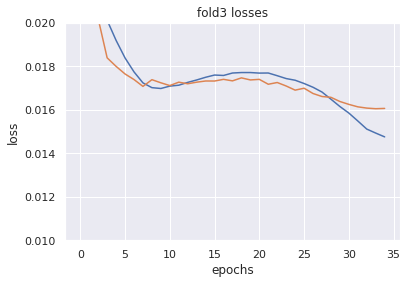

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73548, train_metric: 0.73547
valid_loss: 0.64142, valid_metric: 0.64136
-----EPOCH2-----
train_loss: 0.26756, train_metric: 0.26662
valid_loss: 0.03494, valid_metric: 0.03295
-----EPOCH3-----
train_loss: 0.02824, train_metric: 0.02579
valid_loss: 0.02308, valid_metric: 0.02033
-----EPOCH4-----
train_loss: 0.02323, train_metric: 0.02028
valid_loss: 0.02172, valid_metric: 0.01871
-----EPOCH5-----
train_loss: 0.02229, train_metric: 0.01917
valid_loss: 0.02117, valid_metric: 0.01801
-----EPOCH6-----
train_loss: 0.02170, train_metric: 0.01848
valid_loss: 0.02098, valid_metric: 0.01770
-----EPOCH7-----
train_loss: 0.02092, train_metric: 0.01768
valid_loss: 0.02041, valid_metric: 0.01713
-----EPOCH8-----
train_loss: 0.02043, train_metric: 0.01721
valid_loss: 0.02036, valid_metric: 0.01715
-----EPOCH9-----
train_loss: 0.02018, train_metric: 0.01696
valid_loss: 0.02020, valid_metric: 0.01702
-----EPOCH10-----
train_loss: 0.02015, train_me

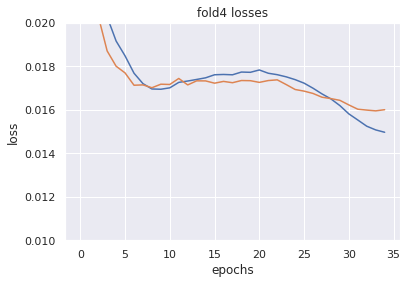

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73552, train_metric: 0.73551
valid_loss: 0.64210, valid_metric: 0.64204
-----EPOCH2-----
train_loss: 0.26958, train_metric: 0.26864
valid_loss: 0.03510, valid_metric: 0.03307
-----EPOCH3-----
train_loss: 0.02836, train_metric: 0.02590
valid_loss: 0.02359, valid_metric: 0.02086
-----EPOCH4-----
train_loss: 0.02341, train_metric: 0.02046
valid_loss: 0.02190, valid_metric: 0.01882
-----EPOCH5-----
train_loss: 0.02213, train_metric: 0.01899
valid_loss: 0.02133, valid_metric: 0.01812
-----EPOCH6-----
train_loss: 0.02159, train_metric: 0.01838
valid_loss: 0.02097, valid_metric: 0.01768
-----EPOCH7-----
train_loss: 0.02092, train_metric: 0.01768
valid_loss: 0.02049, valid_metric: 0.01732
-----EPOCH8-----
train_loss: 0.02037, train_metric: 0.01714
valid_loss: 0.02034, valid_metric: 0.01711
-----EPOCH9-----
train_loss: 0.02017, train_metric: 0.01695
valid_loss: 0.02031, valid_metric: 0.01710
-----EPOCH10-----
train_loss: 0.02011, train_me

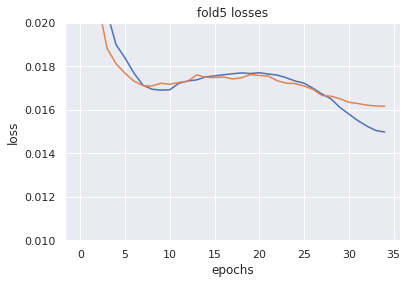

 
SEED : 3

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73620, train_metric: 0.73618
valid_loss: 0.64208, valid_metric: 0.64202
-----EPOCH2-----
train_loss: 0.26985, train_metric: 0.26891
valid_loss: 0.03521, valid_metric: 0.03322
-----EPOCH3-----
train_loss: 0.02788, train_metric: 0.02543
valid_loss: 0.02310, valid_metric: 0.02031
-----EPOCH4-----
train_loss: 0.02321, train_metric: 0.02028
valid_loss: 0.02211, valid_metric: 0.01899
-----EPOCH5-----
train_loss: 0.02244, train_metric: 0.01929
valid_loss: 0.02133, valid_metric: 0.01813
-----EPOCH6-----
train_loss: 0.02155, train_metric: 0.01834
valid_loss: 0.02088, valid_metric: 0.01768
-----EPOCH7-----
train_loss: 0.02082, train_metric: 0.01761
valid_loss: 0.02080, valid_metric: 0.01751
-----EPOCH8-----
train_loss: 0.02053, train_metric: 0.01730
valid_loss: 0.02025, valid_metric: 0.01704
-----EPOCH9-----
train_loss: 0.02018, train_metric: 0.01696
valid_loss: 0.02024, valid_metric: 0.01705
-----EPOCH10-----
train_loss: 0.020

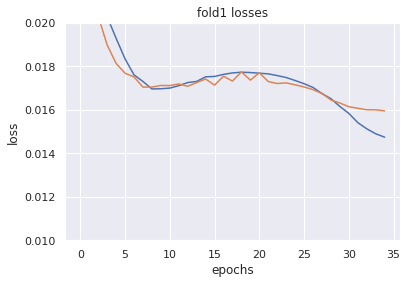

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73598, train_metric: 0.73597
valid_loss: 0.64303, valid_metric: 0.64297
-----EPOCH2-----
train_loss: 0.26801, train_metric: 0.26707
valid_loss: 0.03432, valid_metric: 0.03230
-----EPOCH3-----
train_loss: 0.02834, train_metric: 0.02588
valid_loss: 0.02335, valid_metric: 0.02058
-----EPOCH4-----
train_loss: 0.02343, train_metric: 0.02048
valid_loss: 0.02570, valid_metric: 0.02276
-----EPOCH5-----
train_loss: 0.02256, train_metric: 0.01941
valid_loss: 0.02107, valid_metric: 0.01792
-----EPOCH6-----
train_loss: 0.02155, train_metric: 0.01834
valid_loss: 0.02117, valid_metric: 0.01796
-----EPOCH7-----
train_loss: 0.02102, train_metric: 0.01778
valid_loss: 0.02050, valid_metric: 0.01731
-----EPOCH8-----
train_loss: 0.02037, train_metric: 0.01714
valid_loss: 0.02037, valid_metric: 0.01716
-----EPOCH9-----
train_loss: 0.02015, train_metric: 0.01693
valid_loss: 0.02019, valid_metric: 0.01700
-----EPOCH10-----
train_loss: 0.02015, train_me

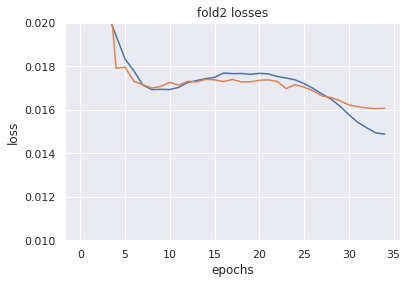

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73625, train_metric: 0.73624
valid_loss: 0.63764, valid_metric: 0.63757
-----EPOCH2-----
train_loss: 0.26864, train_metric: 0.26770
valid_loss: 0.03625, valid_metric: 0.03427
-----EPOCH3-----
train_loss: 0.02803, train_metric: 0.02559
valid_loss: 0.02288, valid_metric: 0.02010
-----EPOCH4-----
train_loss: 0.02330, train_metric: 0.02037
valid_loss: 0.02158, valid_metric: 0.01847
-----EPOCH5-----
train_loss: 0.02224, train_metric: 0.01911
valid_loss: 0.02119, valid_metric: 0.01807
-----EPOCH6-----
train_loss: 0.02162, train_metric: 0.01841
valid_loss: 0.02073, valid_metric: 0.01758
-----EPOCH7-----
train_loss: 0.02096, train_metric: 0.01773
valid_loss: 0.02039, valid_metric: 0.01715
-----EPOCH8-----
train_loss: 0.02036, train_metric: 0.01713
valid_loss: 0.02025, valid_metric: 0.01703
-----EPOCH9-----
train_loss: 0.02019, train_metric: 0.01697
valid_loss: 0.02022, valid_metric: 0.01701
-----EPOCH10-----
train_loss: 0.02014, train_me

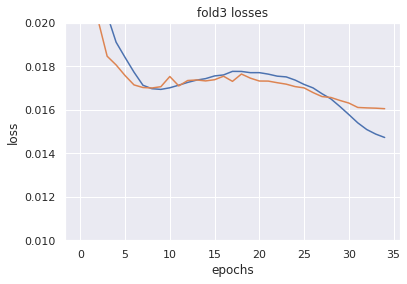

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73667, train_metric: 0.73666
valid_loss: 0.64227, valid_metric: 0.64221
-----EPOCH2-----
train_loss: 0.26949, train_metric: 0.26856
valid_loss: 0.03458, valid_metric: 0.03261
-----EPOCH3-----
train_loss: 0.02792, train_metric: 0.02547
valid_loss: 0.02407, valid_metric: 0.02128
-----EPOCH4-----
train_loss: 0.02332, train_metric: 0.02037
valid_loss: 0.02176, valid_metric: 0.01865
-----EPOCH5-----
train_loss: 0.02212, train_metric: 0.01899
valid_loss: 0.02103, valid_metric: 0.01775
-----EPOCH6-----
train_loss: 0.02156, train_metric: 0.01835
valid_loss: 0.02120, valid_metric: 0.01811
-----EPOCH7-----
train_loss: 0.02096, train_metric: 0.01773
valid_loss: 0.02040, valid_metric: 0.01721
-----EPOCH8-----
train_loss: 0.02035, train_metric: 0.01712
valid_loss: 0.02016, valid_metric: 0.01692
-----EPOCH9-----
train_loss: 0.02013, train_metric: 0.01691
valid_loss: 0.02038, valid_metric: 0.01723
-----EPOCH10-----
train_loss: 0.02012, train_me

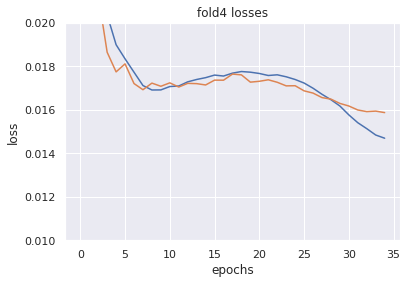

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73699, train_metric: 0.73698
valid_loss: 0.64457, valid_metric: 0.64451
-----EPOCH2-----
train_loss: 0.27120, train_metric: 0.27027
valid_loss: 0.03540, valid_metric: 0.03341
-----EPOCH3-----
train_loss: 0.02815, train_metric: 0.02570
valid_loss: 0.02339, valid_metric: 0.02061
-----EPOCH4-----
train_loss: 0.02326, train_metric: 0.02033
valid_loss: 0.02226, valid_metric: 0.01930
-----EPOCH5-----
train_loss: 0.02219, train_metric: 0.01907
valid_loss: 0.02148, valid_metric: 0.01829
-----EPOCH6-----
train_loss: 0.02155, train_metric: 0.01834
valid_loss: 0.02092, valid_metric: 0.01774
-----EPOCH7-----
train_loss: 0.02093, train_metric: 0.01769
valid_loss: 0.02069, valid_metric: 0.01746
-----EPOCH8-----
train_loss: 0.02039, train_metric: 0.01716
valid_loss: 0.02044, valid_metric: 0.01722
-----EPOCH9-----
train_loss: 0.02010, train_metric: 0.01688
valid_loss: 0.02037, valid_metric: 0.01717
-----EPOCH10-----
train_loss: 0.02012, train_me

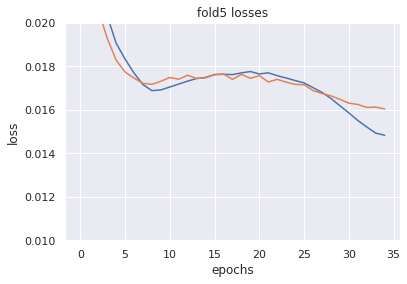

 
SEED : 4

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73754, train_metric: 0.73753
valid_loss: 0.64301, valid_metric: 0.64295
-----EPOCH2-----
train_loss: 0.27162, train_metric: 0.27068
valid_loss: 0.03504, valid_metric: 0.03304
-----EPOCH3-----
train_loss: 0.02809, train_metric: 0.02564
valid_loss: 0.02319, valid_metric: 0.02042
-----EPOCH4-----
train_loss: 0.02313, train_metric: 0.02020
valid_loss: 0.02189, valid_metric: 0.01885
-----EPOCH5-----
train_loss: 0.02233, train_metric: 0.01920
valid_loss: 0.02129, valid_metric: 0.01808
-----EPOCH6-----
train_loss: 0.02149, train_metric: 0.01828
valid_loss: 0.02101, valid_metric: 0.01785
-----EPOCH7-----
train_loss: 0.02097, train_metric: 0.01773
valid_loss: 0.02066, valid_metric: 0.01747
-----EPOCH8-----
train_loss: 0.02044, train_metric: 0.01722
valid_loss: 0.02036, valid_metric: 0.01715
-----EPOCH9-----
train_loss: 0.02015, train_metric: 0.01693
valid_loss: 0.02034, valid_metric: 0.01712
-----EPOCH10-----
train_loss: 0.020

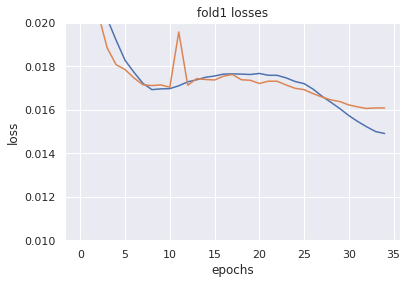

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73746, train_metric: 0.73745
valid_loss: 0.64384, valid_metric: 0.64378
-----EPOCH2-----
train_loss: 0.27049, train_metric: 0.26956
valid_loss: 0.03521, valid_metric: 0.03325
-----EPOCH3-----
train_loss: 0.02785, train_metric: 0.02541
valid_loss: 0.02322, valid_metric: 0.02049
-----EPOCH4-----
train_loss: 0.02313, train_metric: 0.02020
valid_loss: 0.02177, valid_metric: 0.01873
-----EPOCH5-----
train_loss: 0.02228, train_metric: 0.01914
valid_loss: 0.02128, valid_metric: 0.01810
-----EPOCH6-----
train_loss: 0.02165, train_metric: 0.01844
valid_loss: 0.02084, valid_metric: 0.01765
-----EPOCH7-----
train_loss: 0.02088, train_metric: 0.01765
valid_loss: 0.02073, valid_metric: 0.01755
-----EPOCH8-----
train_loss: 0.02037, train_metric: 0.01715
valid_loss: 0.02034, valid_metric: 0.01714
-----EPOCH9-----
train_loss: 0.02014, train_metric: 0.01692
valid_loss: 0.02033, valid_metric: 0.01713
-----EPOCH10-----
train_loss: 0.02013, train_me

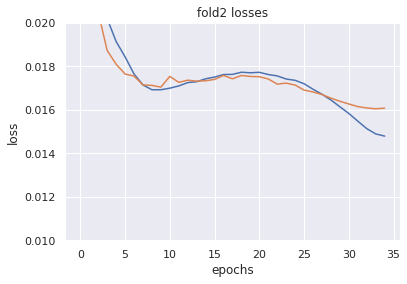

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73757, train_metric: 0.73756
valid_loss: 0.64202, valid_metric: 0.64195
-----EPOCH2-----
train_loss: 0.27119, train_metric: 0.27026
valid_loss: 0.03598, valid_metric: 0.03397
-----EPOCH3-----
train_loss: 0.02799, train_metric: 0.02554
valid_loss: 0.02328, valid_metric: 0.02055
-----EPOCH4-----
train_loss: 0.02339, train_metric: 0.02045
valid_loss: 0.02170, valid_metric: 0.01856
-----EPOCH5-----
train_loss: 0.02220, train_metric: 0.01907
valid_loss: 0.02094, valid_metric: 0.01778
-----EPOCH6-----
train_loss: 0.02143, train_metric: 0.01823
valid_loss: 0.02071, valid_metric: 0.01751
-----EPOCH7-----
train_loss: 0.02079, train_metric: 0.01756
valid_loss: 0.02043, valid_metric: 0.01721
-----EPOCH8-----
train_loss: 0.02038, train_metric: 0.01715
valid_loss: 0.02018, valid_metric: 0.01698
-----EPOCH9-----
train_loss: 0.02009, train_metric: 0.01687
valid_loss: 0.02020, valid_metric: 0.01690
-----EPOCH10-----
train_loss: 0.02015, train_me

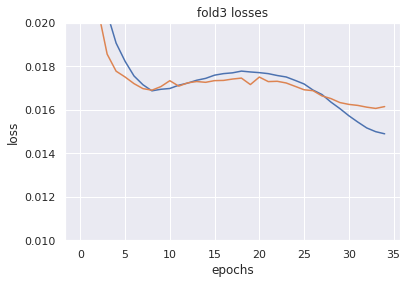

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73694, train_metric: 0.73693
valid_loss: 0.64038, valid_metric: 0.64032
-----EPOCH2-----
train_loss: 0.26941, train_metric: 0.26847
valid_loss: 0.03447, valid_metric: 0.03245
-----EPOCH3-----
train_loss: 0.02803, train_metric: 0.02560
valid_loss: 0.02339, valid_metric: 0.02061
-----EPOCH4-----
train_loss: 0.02311, train_metric: 0.02018
valid_loss: 0.02157, valid_metric: 0.01855
-----EPOCH5-----
train_loss: 0.02219, train_metric: 0.01908
valid_loss: 0.02151, valid_metric: 0.01829
-----EPOCH6-----
train_loss: 0.02158, train_metric: 0.01837
valid_loss: 0.02085, valid_metric: 0.01769
-----EPOCH7-----
train_loss: 0.02093, train_metric: 0.01770
valid_loss: 0.02061, valid_metric: 0.01735
-----EPOCH8-----
train_loss: 0.02034, train_metric: 0.01711
valid_loss: 0.02030, valid_metric: 0.01705
-----EPOCH9-----
train_loss: 0.02009, train_metric: 0.01688
valid_loss: 0.02017, valid_metric: 0.01700
-----EPOCH10-----
train_loss: 0.02015, train_me

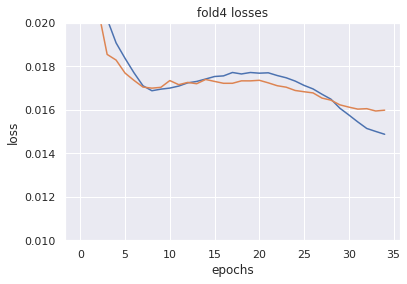

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73756, train_metric: 0.73755
valid_loss: 0.64620, valid_metric: 0.64614
-----EPOCH2-----
train_loss: 0.27159, train_metric: 0.27066
valid_loss: 0.03440, valid_metric: 0.03242
-----EPOCH3-----
train_loss: 0.02794, train_metric: 0.02550
valid_loss: 0.02293, valid_metric: 0.02015
-----EPOCH4-----
train_loss: 0.02313, train_metric: 0.02019
valid_loss: 0.02162, valid_metric: 0.01863
-----EPOCH5-----
train_loss: 0.02218, train_metric: 0.01905
valid_loss: 0.02141, valid_metric: 0.01821
-----EPOCH6-----
train_loss: 0.02166, train_metric: 0.01844
valid_loss: 0.02086, valid_metric: 0.01767
-----EPOCH7-----
train_loss: 0.02092, train_metric: 0.01769
valid_loss: 0.02071, valid_metric: 0.01746
-----EPOCH8-----
train_loss: 0.02040, train_metric: 0.01718
valid_loss: 0.02051, valid_metric: 0.01730
-----EPOCH9-----
train_loss: 0.02014, train_metric: 0.01692
valid_loss: 0.02032, valid_metric: 0.01712
-----EPOCH10-----
train_loss: 0.02011, train_me

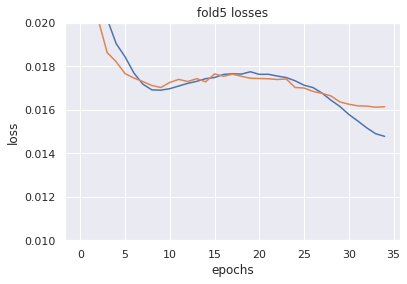

 
SEED : 5

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73757, train_metric: 0.73756
valid_loss: 0.65004, valid_metric: 0.64999
-----EPOCH2-----
train_loss: 0.26835, train_metric: 0.26741
valid_loss: 0.03490, valid_metric: 0.03293
-----EPOCH3-----
train_loss: 0.02773, train_metric: 0.02530
valid_loss: 0.02308, valid_metric: 0.02033
-----EPOCH4-----
train_loss: 0.02326, train_metric: 0.02034
valid_loss: 0.02195, valid_metric: 0.01884
-----EPOCH5-----
train_loss: 0.02218, train_metric: 0.01906
valid_loss: 0.02145, valid_metric: 0.01829
-----EPOCH6-----
train_loss: 0.02147, train_metric: 0.01827
valid_loss: 0.02074, valid_metric: 0.01752
-----EPOCH7-----
train_loss: 0.02084, train_metric: 0.01762
valid_loss: 0.02064, valid_metric: 0.01742
-----EPOCH8-----
train_loss: 0.02037, train_metric: 0.01714
valid_loss: 0.02025, valid_metric: 0.01704
-----EPOCH9-----
train_loss: 0.02012, train_metric: 0.01692
valid_loss: 0.02032, valid_metric: 0.01712
-----EPOCH10-----
train_loss: 0.020

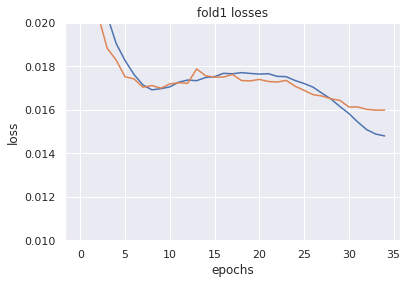

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73804, train_metric: 0.73803
valid_loss: 0.64941, valid_metric: 0.64935
-----EPOCH2-----
train_loss: 0.27097, train_metric: 0.27003
valid_loss: 0.03400, valid_metric: 0.03200
-----EPOCH3-----
train_loss: 0.02815, train_metric: 0.02570
valid_loss: 0.02324, valid_metric: 0.02051
-----EPOCH4-----
train_loss: 0.02356, train_metric: 0.02062
valid_loss: 0.02217, valid_metric: 0.01911
-----EPOCH5-----
train_loss: 0.02219, train_metric: 0.01905
valid_loss: 0.02133, valid_metric: 0.01813
-----EPOCH6-----
train_loss: 0.02144, train_metric: 0.01824
valid_loss: 0.02099, valid_metric: 0.01777
-----EPOCH7-----
train_loss: 0.02084, train_metric: 0.01762
valid_loss: 0.02042, valid_metric: 0.01720
-----EPOCH8-----
train_loss: 0.02057, train_metric: 0.01734
valid_loss: 0.02042, valid_metric: 0.01721
-----EPOCH9-----
train_loss: 0.02015, train_metric: 0.01693
valid_loss: 0.02038, valid_metric: 0.01721
-----EPOCH10-----
train_loss: 0.02010, train_me

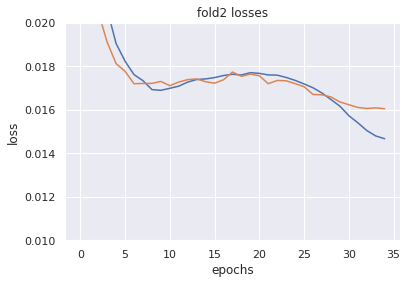

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73788, train_metric: 0.73787
valid_loss: 0.65007, valid_metric: 0.65002
-----EPOCH2-----
train_loss: 0.27304, train_metric: 0.27211
valid_loss: 0.03491, valid_metric: 0.03293
-----EPOCH3-----
train_loss: 0.02816, train_metric: 0.02572
valid_loss: 0.02324, valid_metric: 0.02046
-----EPOCH4-----
train_loss: 0.02373, train_metric: 0.02075
valid_loss: 0.02175, valid_metric: 0.01868
-----EPOCH5-----
train_loss: 0.02236, train_metric: 0.01923
valid_loss: 0.02164, valid_metric: 0.01849
-----EPOCH6-----
train_loss: 0.02160, train_metric: 0.01840
valid_loss: 0.02067, valid_metric: 0.01749
-----EPOCH7-----
train_loss: 0.02097, train_metric: 0.01775
valid_loss: 0.02046, valid_metric: 0.01730
-----EPOCH8-----
train_loss: 0.02050, train_metric: 0.01728
valid_loss: 0.02032, valid_metric: 0.01711
-----EPOCH9-----
train_loss: 0.02015, train_metric: 0.01694
valid_loss: 0.02052, valid_metric: 0.01732
-----EPOCH10-----
train_loss: 0.02019, train_me

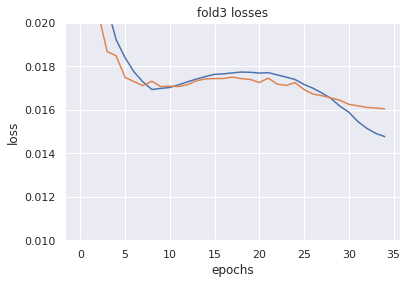

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73759, train_metric: 0.73758
valid_loss: 0.65242, valid_metric: 0.65237
-----EPOCH2-----
train_loss: 0.26903, train_metric: 0.26809
valid_loss: 0.03451, valid_metric: 0.03246
-----EPOCH3-----
train_loss: 0.02811, train_metric: 0.02567
valid_loss: 0.02313, valid_metric: 0.02037
-----EPOCH4-----
train_loss: 0.02320, train_metric: 0.02027
valid_loss: 0.02170, valid_metric: 0.01861
-----EPOCH5-----
train_loss: 0.02217, train_metric: 0.01905
valid_loss: 0.02119, valid_metric: 0.01800
-----EPOCH6-----
train_loss: 0.02144, train_metric: 0.01823
valid_loss: 0.02070, valid_metric: 0.01746
-----EPOCH7-----
train_loss: 0.02083, train_metric: 0.01760
valid_loss: 0.02043, valid_metric: 0.01720
-----EPOCH8-----
train_loss: 0.02039, train_metric: 0.01716
valid_loss: 0.02042, valid_metric: 0.01720
-----EPOCH9-----
train_loss: 0.02011, train_metric: 0.01689
valid_loss: 0.02027, valid_metric: 0.01705
-----EPOCH10-----
train_loss: 0.02013, train_me

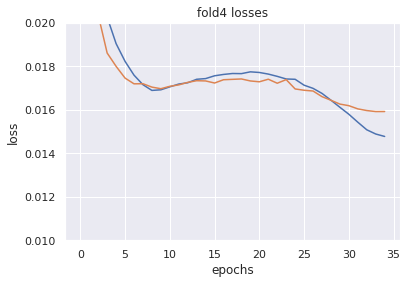

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73790, train_metric: 0.73789
valid_loss: 0.64564, valid_metric: 0.64559
-----EPOCH2-----
train_loss: 0.27019, train_metric: 0.26925
valid_loss: 0.03526, valid_metric: 0.03328
-----EPOCH3-----
train_loss: 0.02800, train_metric: 0.02555
valid_loss: 0.02395, valid_metric: 0.02122
-----EPOCH4-----
train_loss: 0.02330, train_metric: 0.02037
valid_loss: 0.02165, valid_metric: 0.01849
-----EPOCH5-----
train_loss: 0.02214, train_metric: 0.01902
valid_loss: 0.02126, valid_metric: 0.01814
-----EPOCH6-----
train_loss: 0.02199, train_metric: 0.01878
valid_loss: 0.02094, valid_metric: 0.01769
-----EPOCH7-----
train_loss: 0.02101, train_metric: 0.01779
valid_loss: 0.02073, valid_metric: 0.01752
-----EPOCH8-----
train_loss: 0.02044, train_metric: 0.01721
valid_loss: 0.02050, valid_metric: 0.01730
-----EPOCH9-----
train_loss: 0.02022, train_metric: 0.01701
valid_loss: 0.02048, valid_metric: 0.01732
-----EPOCH10-----
train_loss: 0.02013, train_me

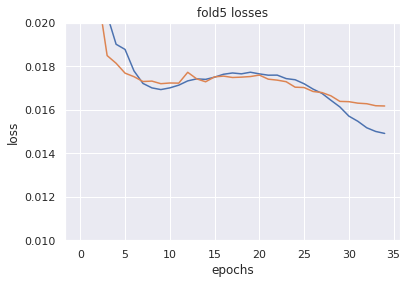

 
SEED : 6

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73577, train_metric: 0.73576
valid_loss: 0.64590, valid_metric: 0.64584
-----EPOCH2-----
train_loss: 0.26832, train_metric: 0.26738
valid_loss: 0.03515, valid_metric: 0.03315
-----EPOCH3-----
train_loss: 0.02778, train_metric: 0.02534
valid_loss: 0.02325, valid_metric: 0.02051
-----EPOCH4-----
train_loss: 0.02305, train_metric: 0.02013
valid_loss: 0.02189, valid_metric: 0.01887
-----EPOCH5-----
train_loss: 0.02241, train_metric: 0.01928
valid_loss: 0.02126, valid_metric: 0.01808
-----EPOCH6-----
train_loss: 0.02154, train_metric: 0.01834
valid_loss: 0.02086, valid_metric: 0.01766
-----EPOCH7-----
train_loss: 0.02086, train_metric: 0.01764
valid_loss: 0.02061, valid_metric: 0.01737
-----EPOCH8-----
train_loss: 0.02040, train_metric: 0.01717
valid_loss: 0.02037, valid_metric: 0.01710
-----EPOCH9-----
train_loss: 0.02012, train_metric: 0.01690
valid_loss: 0.02041, valid_metric: 0.01718
-----EPOCH10-----
train_loss: 0.020

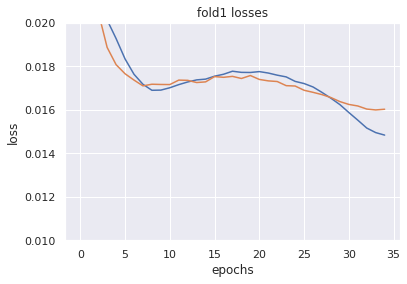

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73552, train_metric: 0.73551
valid_loss: 0.64300, valid_metric: 0.64294
-----EPOCH2-----
train_loss: 0.26913, train_metric: 0.26819
valid_loss: 0.03632, valid_metric: 0.03435
-----EPOCH3-----
train_loss: 0.02808, train_metric: 0.02563
valid_loss: 0.02296, valid_metric: 0.02020
-----EPOCH4-----
train_loss: 0.02326, train_metric: 0.02032
valid_loss: 0.02270, valid_metric: 0.01969
-----EPOCH5-----
train_loss: 0.02233, train_metric: 0.01919
valid_loss: 0.02123, valid_metric: 0.01804
-----EPOCH6-----
train_loss: 0.02143, train_metric: 0.01822
valid_loss: 0.02085, valid_metric: 0.01759
-----EPOCH7-----
train_loss: 0.02082, train_metric: 0.01760
valid_loss: 0.02079, valid_metric: 0.01758
-----EPOCH8-----
train_loss: 0.02042, train_metric: 0.01719
valid_loss: 0.02045, valid_metric: 0.01725
-----EPOCH9-----
train_loss: 0.02015, train_metric: 0.01694
valid_loss: 0.02017, valid_metric: 0.01696
-----EPOCH10-----
train_loss: 0.02013, train_me

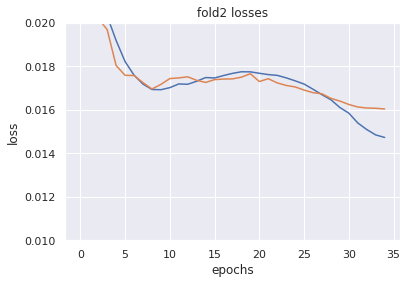

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73577, train_metric: 0.73576
valid_loss: 0.64841, valid_metric: 0.64836
-----EPOCH2-----
train_loss: 0.27137, train_metric: 0.27044
valid_loss: 0.03438, valid_metric: 0.03238
-----EPOCH3-----
train_loss: 0.02809, train_metric: 0.02564
valid_loss: 0.02305, valid_metric: 0.02027
-----EPOCH4-----
train_loss: 0.02344, train_metric: 0.02050
valid_loss: 0.02293, valid_metric: 0.02009
-----EPOCH5-----
train_loss: 0.02239, train_metric: 0.01926
valid_loss: 0.02114, valid_metric: 0.01794
-----EPOCH6-----
train_loss: 0.02162, train_metric: 0.01840
valid_loss: 0.02073, valid_metric: 0.01751
-----EPOCH7-----
train_loss: 0.02107, train_metric: 0.01784
valid_loss: 0.02042, valid_metric: 0.01721
-----EPOCH8-----
train_loss: 0.02048, train_metric: 0.01726
valid_loss: 0.02031, valid_metric: 0.01704
-----EPOCH9-----
train_loss: 0.02021, train_metric: 0.01699
valid_loss: 0.02017, valid_metric: 0.01695
-----EPOCH10-----
train_loss: 0.02016, train_me

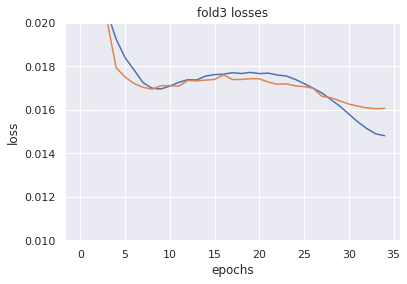

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73589, train_metric: 0.73588
valid_loss: 0.64511, valid_metric: 0.64505
-----EPOCH2-----
train_loss: 0.26812, train_metric: 0.26718
valid_loss: 0.03382, valid_metric: 0.03182
-----EPOCH3-----
train_loss: 0.02802, train_metric: 0.02558
valid_loss: 0.02337, valid_metric: 0.02065
-----EPOCH4-----
train_loss: 0.02321, train_metric: 0.02028
valid_loss: 0.02164, valid_metric: 0.01851
-----EPOCH5-----
train_loss: 0.02205, train_metric: 0.01893
valid_loss: 0.02112, valid_metric: 0.01793
-----EPOCH6-----
train_loss: 0.02158, train_metric: 0.01838
valid_loss: 0.02085, valid_metric: 0.01761
-----EPOCH7-----
train_loss: 0.02090, train_metric: 0.01767
valid_loss: 0.02048, valid_metric: 0.01730
-----EPOCH8-----
train_loss: 0.02041, train_metric: 0.01718
valid_loss: 0.02030, valid_metric: 0.01707
-----EPOCH9-----
train_loss: 0.02020, train_metric: 0.01698
valid_loss: 0.02016, valid_metric: 0.01695
-----EPOCH10-----
train_loss: 0.02017, train_me

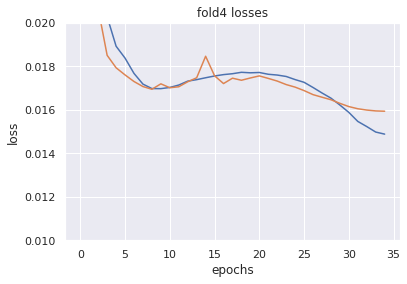

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73592, train_metric: 0.73591
valid_loss: 0.64971, valid_metric: 0.64966
-----EPOCH2-----
train_loss: 0.26823, train_metric: 0.26728
valid_loss: 0.03522, valid_metric: 0.03324
-----EPOCH3-----
train_loss: 0.02823, train_metric: 0.02578
valid_loss: 0.02361, valid_metric: 0.02084
-----EPOCH4-----
train_loss: 0.02324, train_metric: 0.02030
valid_loss: 0.02185, valid_metric: 0.01887
-----EPOCH5-----
train_loss: 0.02221, train_metric: 0.01909
valid_loss: 0.02139, valid_metric: 0.01819
-----EPOCH6-----
train_loss: 0.02155, train_metric: 0.01835
valid_loss: 0.02098, valid_metric: 0.01778
-----EPOCH7-----
train_loss: 0.02090, train_metric: 0.01767
valid_loss: 0.02049, valid_metric: 0.01728
-----EPOCH8-----
train_loss: 0.02038, train_metric: 0.01715
valid_loss: 0.02039, valid_metric: 0.01719
-----EPOCH9-----
train_loss: 0.02017, train_metric: 0.01696
valid_loss: 0.02025, valid_metric: 0.01708
-----EPOCH10-----
train_loss: 0.02015, train_me

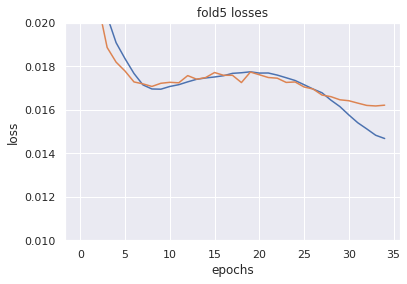

 
SEED : 7

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73727, train_metric: 0.73726
valid_loss: 0.64515, valid_metric: 0.64509
-----EPOCH2-----
train_loss: 0.26921, train_metric: 0.26827
valid_loss: 0.03479, valid_metric: 0.03281
-----EPOCH3-----
train_loss: 0.02841, train_metric: 0.02595
valid_loss: 0.02348, valid_metric: 0.02067
-----EPOCH4-----
train_loss: 0.02355, train_metric: 0.02060
valid_loss: 0.02185, valid_metric: 0.01880
-----EPOCH5-----
train_loss: 0.02223, train_metric: 0.01909
valid_loss: 0.02162, valid_metric: 0.01842
-----EPOCH6-----
train_loss: 0.02147, train_metric: 0.01826
valid_loss: 0.02082, valid_metric: 0.01758
-----EPOCH7-----
train_loss: 0.02087, train_metric: 0.01764
valid_loss: 0.02085, valid_metric: 0.01754
-----EPOCH8-----
train_loss: 0.02044, train_metric: 0.01720
valid_loss: 0.02029, valid_metric: 0.01710
-----EPOCH9-----
train_loss: 0.02013, train_metric: 0.01691
valid_loss: 0.02029, valid_metric: 0.01704
-----EPOCH10-----
train_loss: 0.020

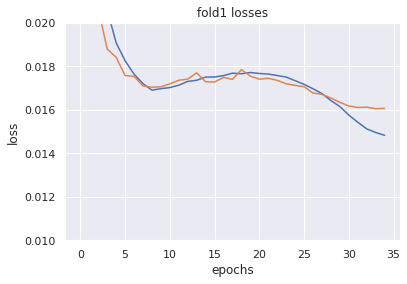

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73779, train_metric: 0.73778
valid_loss: 0.64552, valid_metric: 0.64546
-----EPOCH2-----
train_loss: 0.27064, train_metric: 0.26971
valid_loss: 0.03426, valid_metric: 0.03226
-----EPOCH3-----
train_loss: 0.02805, train_metric: 0.02561
valid_loss: 0.02342, valid_metric: 0.02065
-----EPOCH4-----
train_loss: 0.02351, train_metric: 0.02054
valid_loss: 0.02175, valid_metric: 0.01873
-----EPOCH5-----
train_loss: 0.02230, train_metric: 0.01915
valid_loss: 0.02123, valid_metric: 0.01807
-----EPOCH6-----
train_loss: 0.02159, train_metric: 0.01837
valid_loss: 0.02082, valid_metric: 0.01759
-----EPOCH7-----
train_loss: 0.02089, train_metric: 0.01765
valid_loss: 0.02081, valid_metric: 0.01758
-----EPOCH8-----
train_loss: 0.02039, train_metric: 0.01716
valid_loss: 0.02035, valid_metric: 0.01710
-----EPOCH9-----
train_loss: 0.02014, train_metric: 0.01692
valid_loss: 0.02018, valid_metric: 0.01699
-----EPOCH10-----
train_loss: 0.02013, train_me

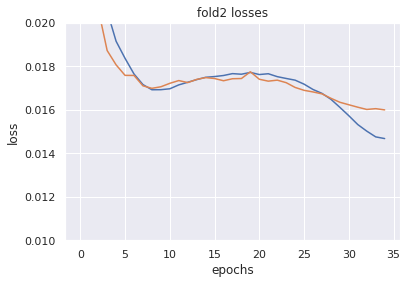

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73753, train_metric: 0.73752
valid_loss: 0.64462, valid_metric: 0.64456
-----EPOCH2-----
train_loss: 0.27005, train_metric: 0.26911
valid_loss: 0.03366, valid_metric: 0.03165
-----EPOCH3-----
train_loss: 0.02814, train_metric: 0.02570
valid_loss: 0.02321, valid_metric: 0.02042
-----EPOCH4-----
train_loss: 0.02327, train_metric: 0.02034
valid_loss: 0.02193, valid_metric: 0.01889
-----EPOCH5-----
train_loss: 0.02222, train_metric: 0.01910
valid_loss: 0.02105, valid_metric: 0.01789
-----EPOCH6-----
train_loss: 0.02161, train_metric: 0.01840
valid_loss: 0.02092, valid_metric: 0.01771
-----EPOCH7-----
train_loss: 0.02099, train_metric: 0.01776
valid_loss: 0.02047, valid_metric: 0.01729
-----EPOCH8-----
train_loss: 0.02045, train_metric: 0.01721
valid_loss: 0.02031, valid_metric: 0.01708
-----EPOCH9-----
train_loss: 0.02011, train_metric: 0.01689
valid_loss: 0.02021, valid_metric: 0.01704
-----EPOCH10-----
train_loss: 0.02022, train_me

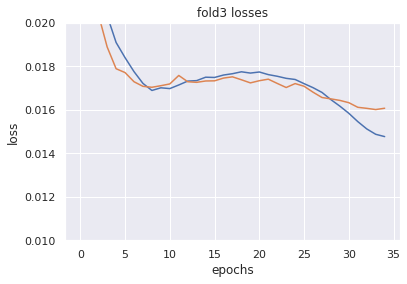

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73759, train_metric: 0.73758
valid_loss: 0.64271, valid_metric: 0.64265
-----EPOCH2-----
train_loss: 0.27047, train_metric: 0.26954
valid_loss: 0.03446, valid_metric: 0.03243
-----EPOCH3-----
train_loss: 0.02797, train_metric: 0.02553
valid_loss: 0.02316, valid_metric: 0.02041
-----EPOCH4-----
train_loss: 0.02391, train_metric: 0.02097
valid_loss: 0.02255, valid_metric: 0.01942
-----EPOCH5-----
train_loss: 0.02238, train_metric: 0.01923
valid_loss: 0.02131, valid_metric: 0.01809
-----EPOCH6-----
train_loss: 0.02167, train_metric: 0.01846
valid_loss: 0.02080, valid_metric: 0.01761
-----EPOCH7-----
train_loss: 0.02093, train_metric: 0.01770
valid_loss: 0.02057, valid_metric: 0.01734
-----EPOCH8-----
train_loss: 0.02049, train_metric: 0.01726
valid_loss: 0.02023, valid_metric: 0.01700
-----EPOCH9-----
train_loss: 0.02015, train_metric: 0.01693
valid_loss: 0.02032, valid_metric: 0.01714
-----EPOCH10-----
train_loss: 0.02017, train_me

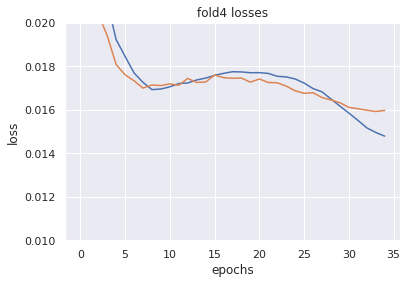

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73772, train_metric: 0.73771
valid_loss: 0.64701, valid_metric: 0.64695
-----EPOCH2-----
train_loss: 0.27195, train_metric: 0.27101
valid_loss: 0.03522, valid_metric: 0.03325
-----EPOCH3-----
train_loss: 0.02816, train_metric: 0.02571
valid_loss: 0.02332, valid_metric: 0.02056
-----EPOCH4-----
train_loss: 0.02351, train_metric: 0.02054
valid_loss: 0.02178, valid_metric: 0.01874
-----EPOCH5-----
train_loss: 0.02241, train_metric: 0.01927
valid_loss: 0.02149, valid_metric: 0.01815
-----EPOCH6-----
train_loss: 0.02145, train_metric: 0.01823
valid_loss: 0.02099, valid_metric: 0.01773
-----EPOCH7-----
train_loss: 0.02086, train_metric: 0.01762
valid_loss: 0.02049, valid_metric: 0.01728
-----EPOCH8-----
train_loss: 0.02036, train_metric: 0.01713
valid_loss: 0.02047, valid_metric: 0.01722
-----EPOCH9-----
train_loss: 0.02020, train_metric: 0.01698
valid_loss: 0.02033, valid_metric: 0.01713
-----EPOCH10-----
train_loss: 0.02014, train_me

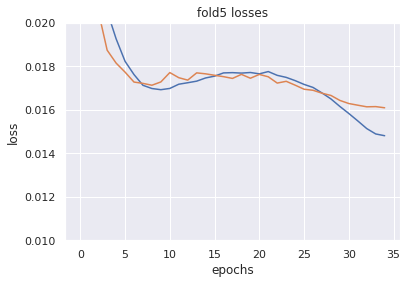

 
SEED : 8

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73602, train_metric: 0.73601
valid_loss: 0.64789, valid_metric: 0.64784
-----EPOCH2-----
train_loss: 0.26912, train_metric: 0.26818
valid_loss: 0.03417, valid_metric: 0.03218
-----EPOCH3-----
train_loss: 0.02800, train_metric: 0.02556
valid_loss: 0.02323, valid_metric: 0.02048
-----EPOCH4-----
train_loss: 0.02328, train_metric: 0.02034
valid_loss: 0.02203, valid_metric: 0.01898
-----EPOCH5-----
train_loss: 0.02225, train_metric: 0.01912
valid_loss: 0.02144, valid_metric: 0.01822
-----EPOCH6-----
train_loss: 0.02144, train_metric: 0.01824
valid_loss: 0.02089, valid_metric: 0.01765
-----EPOCH7-----
train_loss: 0.02091, train_metric: 0.01767
valid_loss: 0.02058, valid_metric: 0.01735
-----EPOCH8-----
train_loss: 0.02044, train_metric: 0.01722
valid_loss: 0.02039, valid_metric: 0.01720
-----EPOCH9-----
train_loss: 0.02013, train_metric: 0.01692
valid_loss: 0.02029, valid_metric: 0.01708
-----EPOCH10-----
train_loss: 0.020

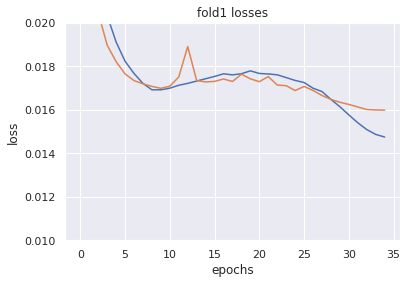

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73639, train_metric: 0.73638
valid_loss: 0.64457, valid_metric: 0.64451
-----EPOCH2-----
train_loss: 0.27055, train_metric: 0.26962
valid_loss: 0.03739, valid_metric: 0.03545
-----EPOCH3-----
train_loss: 0.02806, train_metric: 0.02562
valid_loss: 0.02281, valid_metric: 0.02008
-----EPOCH4-----
train_loss: 0.02319, train_metric: 0.02027
valid_loss: 0.02175, valid_metric: 0.01870
-----EPOCH5-----
train_loss: 0.02214, train_metric: 0.01901
valid_loss: 0.02137, valid_metric: 0.01821
-----EPOCH6-----
train_loss: 0.02151, train_metric: 0.01830
valid_loss: 0.02151, valid_metric: 0.01831
-----EPOCH7-----
train_loss: 0.02088, train_metric: 0.01764
valid_loss: 0.02070, valid_metric: 0.01748
-----EPOCH8-----
train_loss: 0.02038, train_metric: 0.01715
valid_loss: 0.02031, valid_metric: 0.01710
-----EPOCH9-----
train_loss: 0.02012, train_metric: 0.01690
valid_loss: 0.02036, valid_metric: 0.01718
-----EPOCH10-----
train_loss: 0.02010, train_me

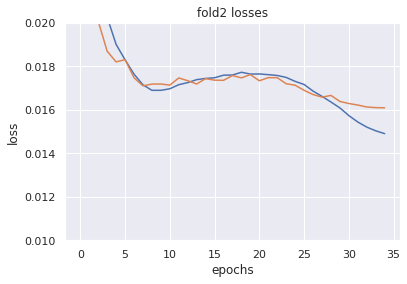

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73663, train_metric: 0.73662
valid_loss: 0.64503, valid_metric: 0.64497
-----EPOCH2-----
train_loss: 0.27055, train_metric: 0.26962
valid_loss: 0.03412, valid_metric: 0.03213
-----EPOCH3-----
train_loss: 0.02821, train_metric: 0.02577
valid_loss: 0.02300, valid_metric: 0.02021
-----EPOCH4-----
train_loss: 0.02347, train_metric: 0.02053
valid_loss: 0.02204, valid_metric: 0.01898
-----EPOCH5-----
train_loss: 0.02240, train_metric: 0.01926
valid_loss: 0.02110, valid_metric: 0.01795
-----EPOCH6-----
train_loss: 0.02172, train_metric: 0.01852
valid_loss: 0.02072, valid_metric: 0.01755
-----EPOCH7-----
train_loss: 0.02097, train_metric: 0.01775
valid_loss: 0.02064, valid_metric: 0.01741
-----EPOCH8-----
train_loss: 0.02047, train_metric: 0.01725
valid_loss: 0.02032, valid_metric: 0.01706
-----EPOCH9-----
train_loss: 0.02025, train_metric: 0.01703
valid_loss: 0.02020, valid_metric: 0.01696
-----EPOCH10-----
train_loss: 0.02014, train_me

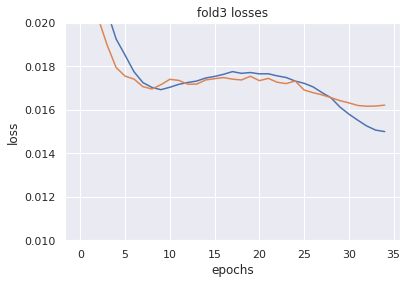

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73626, train_metric: 0.73625
valid_loss: 0.64627, valid_metric: 0.64622
-----EPOCH2-----
train_loss: 0.27128, train_metric: 0.27034
valid_loss: 0.03416, valid_metric: 0.03216
-----EPOCH3-----
train_loss: 0.02787, train_metric: 0.02542
valid_loss: 0.02313, valid_metric: 0.02037
-----EPOCH4-----
train_loss: 0.02317, train_metric: 0.02024
valid_loss: 0.02171, valid_metric: 0.01865
-----EPOCH5-----
train_loss: 0.02243, train_metric: 0.01930
valid_loss: 0.02153, valid_metric: 0.01830
-----EPOCH6-----
train_loss: 0.02161, train_metric: 0.01841
valid_loss: 0.02101, valid_metric: 0.01783
-----EPOCH7-----
train_loss: 0.02118, train_metric: 0.01795
valid_loss: 0.02047, valid_metric: 0.01725
-----EPOCH8-----
train_loss: 0.02044, train_metric: 0.01722
valid_loss: 0.02032, valid_metric: 0.01712
-----EPOCH9-----
train_loss: 0.02020, train_metric: 0.01698
valid_loss: 0.02032, valid_metric: 0.01714
-----EPOCH10-----
train_loss: 0.02014, train_me

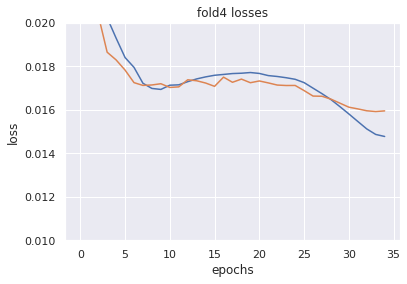

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73632, train_metric: 0.73631
valid_loss: 0.64290, valid_metric: 0.64284
-----EPOCH2-----
train_loss: 0.27131, train_metric: 0.27038
valid_loss: 0.03332, valid_metric: 0.03130
-----EPOCH3-----
train_loss: 0.02849, train_metric: 0.02604
valid_loss: 0.02338, valid_metric: 0.02060
-----EPOCH4-----
train_loss: 0.02331, train_metric: 0.02036
valid_loss: 0.02198, valid_metric: 0.01887
-----EPOCH5-----
train_loss: 0.02215, train_metric: 0.01903
valid_loss: 0.02174, valid_metric: 0.01859
-----EPOCH6-----
train_loss: 0.02162, train_metric: 0.01842
valid_loss: 0.02126, valid_metric: 0.01801
-----EPOCH7-----
train_loss: 0.02101, train_metric: 0.01777
valid_loss: 0.02067, valid_metric: 0.01747
-----EPOCH8-----
train_loss: 0.02043, train_metric: 0.01720
valid_loss: 0.02048, valid_metric: 0.01727
-----EPOCH9-----
train_loss: 0.02009, train_metric: 0.01687
valid_loss: 0.02020, valid_metric: 0.01701
-----EPOCH10-----
train_loss: 0.02006, train_me

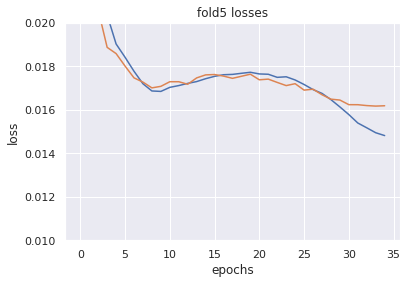

 
SEED : 9

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73715, train_metric: 0.73714
valid_loss: 0.65090, valid_metric: 0.65085
-----EPOCH2-----
train_loss: 0.27183, train_metric: 0.27090
valid_loss: 0.03389, valid_metric: 0.03189
-----EPOCH3-----
train_loss: 0.02814, train_metric: 0.02569
valid_loss: 0.02331, valid_metric: 0.02055
-----EPOCH4-----
train_loss: 0.02322, train_metric: 0.02027
valid_loss: 0.02172, valid_metric: 0.01871
-----EPOCH5-----
train_loss: 0.02258, train_metric: 0.01944
valid_loss: 0.02142, valid_metric: 0.01820
-----EPOCH6-----
train_loss: 0.02155, train_metric: 0.01834
valid_loss: 0.02076, valid_metric: 0.01758
-----EPOCH7-----
train_loss: 0.02093, train_metric: 0.01770
valid_loss: 0.02073, valid_metric: 0.01751
-----EPOCH8-----
train_loss: 0.02052, train_metric: 0.01730
valid_loss: 0.02027, valid_metric: 0.01706
-----EPOCH9-----
train_loss: 0.02017, train_metric: 0.01695
valid_loss: 0.02035, valid_metric: 0.01717
-----EPOCH10-----
train_loss: 0.020

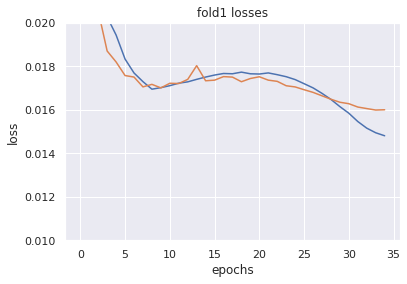

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73685, train_metric: 0.73684
valid_loss: 0.64908, valid_metric: 0.64902
-----EPOCH2-----
train_loss: 0.26947, train_metric: 0.26854
valid_loss: 0.03426, valid_metric: 0.03225
-----EPOCH3-----
train_loss: 0.02822, train_metric: 0.02577
valid_loss: 0.02329, valid_metric: 0.02053
-----EPOCH4-----
train_loss: 0.02316, train_metric: 0.02023
valid_loss: 0.02195, valid_metric: 0.01891
-----EPOCH5-----
train_loss: 0.02225, train_metric: 0.01912
valid_loss: 0.02187, valid_metric: 0.01877
-----EPOCH6-----
train_loss: 0.02157, train_metric: 0.01834
valid_loss: 0.02069, valid_metric: 0.01748
-----EPOCH7-----
train_loss: 0.02084, train_metric: 0.01761
valid_loss: 0.02068, valid_metric: 0.01743
-----EPOCH8-----
train_loss: 0.02045, train_metric: 0.01722
valid_loss: 0.02040, valid_metric: 0.01715
-----EPOCH9-----
train_loss: 0.02012, train_metric: 0.01691
valid_loss: 0.02026, valid_metric: 0.01705
-----EPOCH10-----
train_loss: 0.02016, train_me

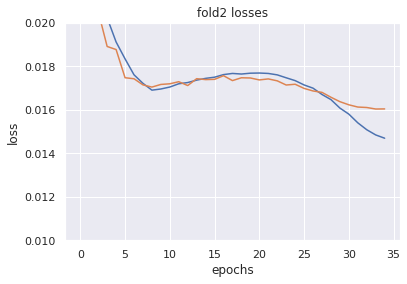

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73709, train_metric: 0.73708
valid_loss: 0.65184, valid_metric: 0.65179
-----EPOCH2-----
train_loss: 0.26995, train_metric: 0.26901
valid_loss: 0.03506, valid_metric: 0.03308
-----EPOCH3-----
train_loss: 0.02827, train_metric: 0.02581
valid_loss: 0.02578, valid_metric: 0.02318
-----EPOCH4-----
train_loss: 0.02349, train_metric: 0.02053
valid_loss: 0.02164, valid_metric: 0.01857
-----EPOCH5-----
train_loss: 0.02210, train_metric: 0.01897
valid_loss: 0.02118, valid_metric: 0.01794
-----EPOCH6-----
train_loss: 0.02185, train_metric: 0.01863
valid_loss: 0.02078, valid_metric: 0.01758
-----EPOCH7-----
train_loss: 0.02094, train_metric: 0.01771
valid_loss: 0.02057, valid_metric: 0.01733
-----EPOCH8-----
train_loss: 0.02047, train_metric: 0.01724
valid_loss: 0.02030, valid_metric: 0.01706
-----EPOCH9-----
train_loss: 0.02018, train_metric: 0.01696
valid_loss: 0.02020, valid_metric: 0.01699
-----EPOCH10-----
train_loss: 0.02018, train_me

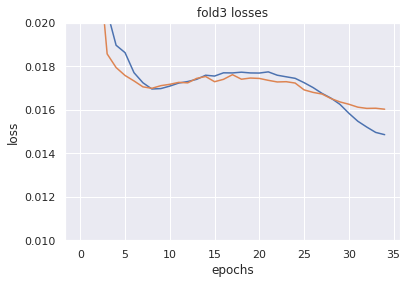

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73680, train_metric: 0.73679
valid_loss: 0.64330, valid_metric: 0.64324
-----EPOCH2-----
train_loss: 0.26986, train_metric: 0.26892
valid_loss: 0.03503, valid_metric: 0.03300
-----EPOCH3-----
train_loss: 0.02818, train_metric: 0.02573
valid_loss: 0.02324, valid_metric: 0.02051
-----EPOCH4-----
train_loss: 0.02328, train_metric: 0.02034
valid_loss: 0.02216, valid_metric: 0.01903
-----EPOCH5-----
train_loss: 0.02236, train_metric: 0.01923
valid_loss: 0.02117, valid_metric: 0.01798
-----EPOCH6-----
train_loss: 0.02161, train_metric: 0.01840
valid_loss: 0.02104, valid_metric: 0.01771
-----EPOCH7-----
train_loss: 0.02103, train_metric: 0.01779
valid_loss: 0.02068, valid_metric: 0.01749
-----EPOCH8-----
train_loss: 0.02048, train_metric: 0.01726
valid_loss: 0.02030, valid_metric: 0.01711
-----EPOCH9-----
train_loss: 0.02022, train_metric: 0.01701
valid_loss: 0.02033, valid_metric: 0.01719
-----EPOCH10-----
train_loss: 0.02017, train_me

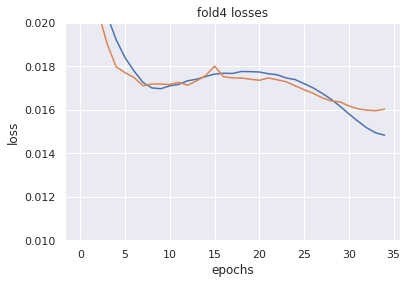

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73656, train_metric: 0.73655
valid_loss: 0.64471, valid_metric: 0.64465
-----EPOCH2-----
train_loss: 0.26855, train_metric: 0.26761
valid_loss: 0.03670, valid_metric: 0.03472
-----EPOCH3-----
train_loss: 0.02846, train_metric: 0.02600
valid_loss: 0.02306, valid_metric: 0.02030
-----EPOCH4-----
train_loss: 0.02334, train_metric: 0.02040
valid_loss: 0.02168, valid_metric: 0.01857
-----EPOCH5-----
train_loss: 0.02217, train_metric: 0.01903
valid_loss: 0.02138, valid_metric: 0.01817
-----EPOCH6-----
train_loss: 0.02160, train_metric: 0.01839
valid_loss: 0.02100, valid_metric: 0.01782
-----EPOCH7-----
train_loss: 0.02094, train_metric: 0.01771
valid_loss: 0.02066, valid_metric: 0.01749
-----EPOCH8-----
train_loss: 0.02045, train_metric: 0.01722
valid_loss: 0.02049, valid_metric: 0.01734
-----EPOCH9-----
train_loss: 0.02020, train_metric: 0.01698
valid_loss: 0.02043, valid_metric: 0.01725
-----EPOCH10-----
train_loss: 0.02017, train_me

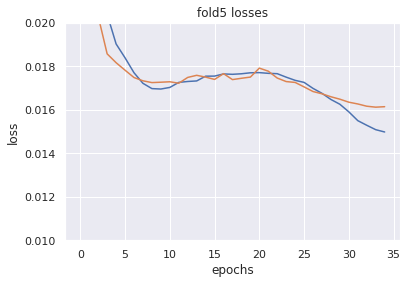

In [35]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))
CVs = list()

print(f'device used: {DEVICE}')

for seed in SEED:
    
    print(f' ')
    print(f'SEED : {seed}')
    print(f'')
    
    oof_, predictions_, CVs_ = run_k_fold(NFOLDS, seed, EPOCHS, LEARNING_RATE)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)
    CVs += CVs_
    
train[target_cols] = oof
test[target_cols] = predictions

In [36]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(
    train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

cv = 0
# cv_indivisual = list()
for i in range(len(target_cols)):
    cv_ = log_loss(y_true[:, i], y_pred[:, i])
#     cv_indivisual.append(cv_)
    cv += cv_ / len(target_cols)
    
auc = 0
for i in range(len(target_cols)):
    auc_ = roc_auc_score(y_true[:, i], y_pred[:, i])
    auc += auc_ / len(target_cols)
    
print(f'CV log_loss: {cv:.6f} +/- {np.std(CVs):.6f}')
print(f'AUC: {auc:.6f}')

CV log_loss: 0.014789 +/- 0.000281
AUC: 0.815932


In [37]:
print('batch_size:64  SEED=[0]  CV=0.015845')
print('AUC=0.684534')

batch_size:64  SEED=[0]  CV=0.015845
AUC=0.684534


In [38]:
file_path = 'oof_Simple.npy'
np.save(file_path, oof)

sub = sample_submission.drop(columns=target_cols).merge(
    test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [39]:
print(f'sample_submission.shape : {sample_submission.shape}')
print(f'sub.shape : {sub.shape}')

sample_submission.shape : (3982, 207)
sub.shape : (3982, 207)
